<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/PitVQA%2B%2B_inference_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download dataset
!gdown 1FoAEY_u0PTAlrscjEifi2om15A83wL78

# unzip dataset
!unzip -q EndoVis-18-VQA.zip

Downloading...
From (original): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78
From (redirected): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78&confirm=t&uuid=de0757f0-b2bd-4f19-bd30-27018a45f067
To: /content/EndoVis-18-VQA.zip
100% 2.71G/2.71G [00:48<00:00, 55.9MB/s]


In [2]:
# download weights
!gdown 1MkKw8sRkG_ffW8sAqbCkdfsY-rECBgLI

Downloading...
From (original): https://drive.google.com/uc?id=1MkKw8sRkG_ffW8sAqbCkdfsY-rECBgLI
From (redirected): https://drive.google.com/uc?id=1MkKw8sRkG_ffW8sAqbCkdfsY-rECBgLI&confirm=t&uuid=35b2ab86-48d7-459b-ba4c-4d35e2f9045a
To: /content/vec_mlr_saved_weights.pth.tar
100% 3.39G/3.39G [00:59<00:00, 56.7MB/s]


In [3]:
!gdown 1Te3qSOZxmRBbqhT1o4-AMH74a2G9kK5_

Downloading...
From (original): https://drive.google.com/uc?id=1Te3qSOZxmRBbqhT1o4-AMH74a2G9kK5_
From (redirected): https://drive.google.com/uc?id=1Te3qSOZxmRBbqhT1o4-AMH74a2G9kK5_&confirm=t&uuid=0eabd6f3-a418-4b44-9926-16121e6bf5a4
To: /content/model.py
100% 8.65k/8.65k [00:00<00:00, 25.0MB/s]


In [4]:
# install libs
!pip install -q timm==0.9.12 fairscale==0.4.13 scikit-learn==1.3.2 evaluate rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 1

## Dataloader

In [5]:
import os
import glob

from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from pathlib import Path

class EndoVis18VQA(Dataset):
    def __init__(self, seq, folder_head, folder_tail):

        self.transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # files, question and answers
        filenames = []
        for curr_seq in seq:
            filenames = filenames + glob.glob(folder_head + str(curr_seq) + folder_tail)
        self.vqas = []
        for file in filenames:
            file_data = open(file, "r")
            lines = [line.strip("\n") for line in file_data if line != "\n"]
            file_data.close()
            for line in lines:
                self.vqas.append([file, line])
        print('Total files: %d | Total question: %.d' % (len(filenames), len(self.vqas)))

    def __len__(self):
        return len(self.vqas)

    def __getitem__(self, idx):
        qa_full_path = Path(self.vqas[idx][0])
        seq_path = qa_full_path.parents[2]
        file_name = self.vqas[idx][0].split('/')[-1]  # / in linux and \\ in windows

        # img
        img_loc = os.path.join(seq_path, 'left_fr', file_name.split('_')[0] + '.png')
        raw_image = Image.open(img_loc).convert('RGB')
        img = self.transform(raw_image)

        # question and answer
        question, answer = self.vqas[idx][1].split('|')
        return img, question, answer

## Model

In [6]:
import math
import torch
import torch.nn as nn

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import ViTModel, BlipTextModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Vector_MoLoRA(nn.Module):
    def __init__(self, base_layer, lora_rank, alpha, mora_rank, dropout):
        super().__init__()
        self.base_layer = base_layer  # original c_atten layer
        self.lora_r = lora_rank
        self.scaling = alpha / lora_rank
        self.mora_r = mora_rank  # one of mora rank elements in the list
        self.in_features = base_layer.weight.shape[0]  # 768
        self.out_features = base_layer.weight.shape[1]  # 2304

        # dropout
        self.dropout = nn.ModuleDict({
            'default': nn.Dropout(p=dropout)
        })

        # MoRA A and B matrices
        self.mora_A = nn.ModuleDict({
            'default': nn.Conv1d(self.mora_r, self.mora_r, bias=False, kernel_size=1)
        })
        # zero init for mora_A
        nn.init.zeros_(self.mora_A['default'].weight)
        self.mora_B = self.mora_A  # not for use

        # LoRA C and D matrices
        self.lora_C = nn.ModuleDict({
            'default': nn.Linear(self.in_features, self.lora_r, bias=False)
        })
        self.lora_D = nn.ModuleDict({
            'default': nn.Linear(self.lora_r, self.out_features, bias=False)
        })
        # Kaiming init for lora_C
        nn.init.kaiming_uniform_(self.lora_C['default'].weight, a=math.sqrt(5))
        # zero init for lora_D
        nn.init.zeros_(self.lora_D['default'].weight)

        # For Embedding layer
        self.lora_embedding_A = nn.ParameterDict({})
        self.lora_embedding_B = nn.ParameterDict({})

    def forward(self, x):  # [32, 32, 768]
        # Original output
        result = self.base_layer(x)  # [32, 32, 2304]
        x = self.dropout['default'](x)  # x is the input for mora

        '''Process with LoRA'''
        lora_out_x = self.lora_D['default'](
            self.lora_C['default'](x)
        )  # [32, 32, 2304]

        '''Process with MoRA'''
        # apply compression before lora_A: RoPE
        in_f, out_f = self.in_features, self.out_features
        r = self.mora_r
        # suppose mora_type = 6
        sum_inter = in_f // r
        rb1 = in_f // r if in_f % r == 0 else in_f // r + 1

        if in_f % r != 0:
            pad_size = r - in_f % r
            x = torch.cat([x, x[..., :pad_size]], dim=-1)
            sum_inter += 1
        in_x = x.view(*x.shape[:-1], sum_inter, r)  # [32, 32, 5, 156]

        if not hasattr(self, 'cos') and not hasattr(self, 'sin'):
            inv_freq = 1.0 / (10000 ** (torch.arange(0, r, 2).float() / r))
            t = torch.arange(rb1)
            freqs = torch.outer(t, inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1)
            self.cos = emb.cos().unsqueeze(0).to(x.device).to(x.dtype)
            self.sin = emb.sin().unsqueeze(0).to(x.device).to(x.dtype)

        rh_in_x = torch.cat((-in_x[..., r // 2:], in_x[..., :r // 2]), dim=-1)
        in_x = in_x * self.cos + rh_in_x * self.sin  # [32, 32, 3, 256]

        # rearrange features
        b, c, h, w = in_x.shape  # [16, 32, 3, 256]
        in_x = in_x.view(b, c*h, w).permute(0, 2, 1)  # [16, 256, 96]

        # apply mora_A
        mora_out_x = self.mora_A['default'](in_x)  # [32, 256, 96]
        mora_out_x = mora_out_x.view(b, c, h, w)  # [32, 32, 3, 256]

        # apply decompression after lora_A
        mora_out_x = mora_out_x.view(*x.shape[:-1], -1)[..., :out_f]  # [32, 32, 780]
        if mora_out_x.shape[-1] < out_f:
            repeat_time = out_f // mora_out_x.shape[-1]
            if out_f % mora_out_x.shape[-1] != 0:
                repeat_time += 1
            mora_out_x = torch.cat([mora_out_x] * repeat_time, dim=-1)[..., :out_f]  # [32, 32, 2304]
        return result + mora_out_x + (self.scaling * lora_out_x)

class VectorMoLoRAInitializer:
    def __init__(self, model, mora_base_rank=8, mora_rank_coefficients=None, lora_rank=None, lora_alpha=None, dropout=0.1):
        self.model = model
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha
        self.mora_base_rank = mora_base_rank
        self.dropout = dropout
        self.mora_rank_coefficients = mora_rank_coefficients

    def calculate_mora_ranks(self):
        return [self.mora_base_rank * coeff for coeff in self.mora_rank_coefficients]

    def initialize(self):
        mora_ranks = self.calculate_mora_ranks()

        for param in self.model.transformer.parameters():
            param.requires_grad = False

        for t_layer_i, blk in enumerate(self.model.transformer.h):
            layer_w_qkv = blk.attn.c_attn
            current_mora_rank = mora_ranks[t_layer_i]
            current_lora_rank = self.lora_rank[t_layer_i]
            current_alpha = self.lora_alpha[t_layer_i]
            blk.attn.c_attn = Vector_MoLoRA(base_layer=layer_w_qkv, lora_rank=current_lora_rank, alpha=current_alpha,
                            mora_rank=current_mora_rank, dropout=self.dropout)

        print("Vector MoRA params initialized!")
        return self.model

class PitVQAGen(nn.Module):
    def __init__(self, mora_base_rank=8, mora_rank_coefficients=None, lora_rank=None, lora_alpha=None, dropout=0.1):
        super(PitVQAGen, self).__init__()

        if mora_rank_coefficients is None or lora_rank is None or lora_alpha is None:
            print('Wrong hyperparameters.')

        # visual encoder
        model_name = "google/vit-base-patch16-224-in21k"
        self.visual_encoder = ViTModel.from_pretrained(model_name)

        # tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token  # end of string

        # text encoder
        self.text_encoder = BlipTextModel.from_pretrained("Salesforce/blip-vqa-base")
        original_weights = self.text_encoder.embeddings.word_embeddings.weight.data
        new_vocab_size = len(self.tokenizer)
        embedding_dim = self.text_encoder.embeddings.word_embeddings.embedding_dim
        new_embeddings = nn.Embedding(new_vocab_size, embedding_dim)
        original_vocab_size = original_weights.shape[0]
        new_embeddings.weight.data[:original_vocab_size] = original_weights
        self.text_encoder.embeddings.word_embeddings = new_embeddings

        # gpt2 decoder
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt = VectorMoLoRAInitializer(self.gpt, mora_base_rank=mora_base_rank,
                                           mora_rank_coefficients=mora_rank_coefficients,
                                           lora_rank=lora_rank, lora_alpha=lora_alpha,
                                           dropout=dropout).initialize()

    def forward(self, image, qa_input_ids, qa_att_mask):
        # visual encoder
        image = image.to(device)
        image_embeds = self.visual_encoder(image).last_hidden_state  # torch.Size([bs, 197, 768])
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image.device)  # torch.Size([bs, 197])

        # qa_input_ids = qa_inputs['input_ids']  # torch.Size([bs, 25])
        # qa_att_mask = qa_inputs['attention_mask']

        # multimodal encoder
        text_output = self.text_encoder(input_ids=qa_input_ids,
                        attention_mask=qa_att_mask,
                        encoder_hidden_states=image_embeds,
                        encoder_attention_mask=image_atts,
                        return_dict=True)
        text_embeds = text_output.last_hidden_state  # torch.Size([bs, 25, 768]), args.question_len=25

        # text decoder
        gpt_output = self.gpt(inputs_embeds=text_embeds,
                    encoder_attention_mask=qa_att_mask)  # torch.Size([bs, 25, 50257])
        return gpt_output.logits

## Inference: Batch Greedy Search

In [40]:
import os
import numpy as np
import random

import torch
import torch.utils.data
from torch import nn
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

from PIL import Image
from tqdm import tqdm
import evaluate
import time

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def batch_greedy_search(images, questions, model, tokenizer, max_length, device):
    answers = []
    uncertainties = [[] for _ in range(len(questions))]  # Track uncertainty until EOS per sample
    batch_size = len(questions)

    model.eval()
    with torch.no_grad():
        # Prepare the prompts for the entire batch
        prompt_texts = [f"Question: {q}\nAnswer:" for q in questions]

        # Tokenize the prompts with padding to handle varying lengths
        prompt_inputs = tokenizer(
            prompt_texts,
            return_tensors="pt",
            padding='longest',
            add_special_tokens=False
        )

        # Prepare model inputs
        padded_input_ids = torch.zeros((batch_size, max_length), dtype=torch.long, device=device)
        padded_attention_mask = torch.zeros((batch_size, max_length), device=device)

        orig_length = prompt_inputs['input_ids'].size(1)
        padded_input_ids[:, :orig_length] = prompt_inputs['input_ids']
        padded_attention_mask[:, :orig_length] = prompt_inputs['attention_mask']

        images = images.to(device)

        # Initialize tensors to store generated tokens
        only_answer_ids = torch.empty((batch_size, 0), dtype=torch.long, device=device)

        # Track which sequences have finished generating
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        # Record each sample length (number of non-eos tokens)
        valid_lengths = padded_attention_mask.sum(dim=1).long()
        batch_indices = torch.arange(batch_size, device=device)

        for _ in range(max_length):
            max_valid_lengths = max(valid_lengths).item()
            # Forward pass through the model
            logits = model(image=images, qa_input_ids=padded_input_ids[:, :max_valid_lengths], qa_att_mask=padded_attention_mask[:, :max_valid_lengths])

            # Get next token probabilities and entropy
            last_valid_logits = logits[batch_indices, valid_lengths - 1, :]
            probs = F.softmax(last_valid_logits, dim=-1)

            # Compute entropy for uncertainty
            entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)  # Add small value to avoid log(0)

            # Get next token
            next_token_ids = torch.argmax(last_valid_logits, dim=-1)

            # Track uncertainty until EOS token for each sample
            for i in range(batch_size):
                if not finished[i]:  # Only store uncertainty for unfinished samples
                    uncertainties[i].append(entropy[i].item())

            # Check EOS
            is_eos = (next_token_ids == tokenizer.eos_token_id)
            finished = finished | is_eos  # Update finished status

            padded_input_ids[batch_indices, valid_lengths] = next_token_ids
            padded_attention_mask[batch_indices, valid_lengths] = 1
            valid_lengths += 1

            # Append the selected tokens to the generated_ids
            only_answer_ids = torch.cat([only_answer_ids, next_token_ids.unsqueeze(1)], dim=1)

            # If all sequences have finished, exit early
            if finished.all():
                break

        # Decode the generated tokens into strings
        generated_ids_cpu = only_answer_ids.cpu().tolist()  # Move to CPU and convert to list for processing
        for i in range(batch_size):
            # Find the first occurrence of eos_token_id to truncate the answer
            try:
                eos_index = generated_ids_cpu[i].index(tokenizer.eos_token_id)
                answer_ids = generated_ids_cpu[i][:eos_index]
            except ValueError:
                # If eos_token_id is not found, use all generated tokens
                answer_ids = generated_ids_cpu[i]

            # Decode the token IDs to a string, skipping special tokens
            answer = tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
            answers.append(answer)

    # Compute per-sample uncertainty by averaging entropies over all generated tokens for that sample
    samplewise_unc = [sum(unc) / len(unc) if len(unc) > 0 else 0.0 for unc in uncertainties]

    return answers, samplewise_unc

def validate(args, val_loader, model, tokenizer, device):
    references = []
    hypotheses = []
    samplewise_unc_all = []

    model.eval()
    with torch.no_grad():
        for i, (images, questions, answers) in enumerate(tqdm(val_loader), 0):
            images = images.to(device)
            generated_answers, samplewise_unc = batch_greedy_search(
                images,
                questions,
                model,
                tokenizer,
                max_length=args.seq_length,
                device=device
            )

            references.extend(answers)
            hypotheses.extend(generated_answers)
            samplewise_unc_all.extend(samplewise_unc)

    return references, hypotheses, samplewise_unc_all

def get_nlp_mettics(references, hypotheses):
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    meteor = evaluate.load('meteor')

    # compute HF metrics
    results_bleu = bleu.compute(predictions=hypotheses, references=references)
    results_rouge = rouge.compute(predictions=hypotheses, references=references)
    results_meteor = meteor.compute(predictions=hypotheses, references=references)

    print("HuggingFace Metrics Results:")

    print(f"BLEU-1: {results_bleu['precisions'][0]:.6f}, "
      f"BLEU-2: {results_bleu['precisions'][1]:.6f}, "
      f"BLEU-3: {results_bleu['precisions'][2]:.6f}, "
      f"BLEU-4: {results_bleu['precisions'][3]:.6f}, "
      f"Overall BLEU: {results_bleu['bleu']:.6f}")

    print(f"BLEU-4: {results_bleu['bleu']:.6f}")
    print(f"Rouge1: {results_rouge['rouge1']:.6f}")
    print(f"RougeL: {results_rouge['rougeL']:.6f}")
    print(f"Meteor: {results_meteor['meteor']:.6f}")

    samplewise_rouge = rouge.compute(predictions=hypotheses, references=references, use_aggregator=False)

    return samplewise_rouge['rougeL']

class HyperPara:
    def __init__(self):
        self.epochs = 60
        self.seq_length = 64
        self.workers = 4
        self.batch_size = 256

if __name__ == '__main__':
    # parameters
    mora_base_rank = 8
    mora_coeff = [26, 26, 24, 24, 22, 22, 20, 20, 18, 18, 16, 16]
    lora_rank = [18, 18, 16, 16, 14, 14, 12, 12, 10, 10, 8, 8]
    lora_alpha = [18, 18, 16, 16, 14, 14, 12, 12, 10, 10, 8, 8]
    dropout = 0.1

    random_seed = 42
    seed_everything(random_seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load weights
    model_path = '/content/vec_mlr_saved_weights.pth.tar'
    model = PitVQAGen(mora_base_rank=mora_base_rank, mora_rank_coefficients=mora_coeff,
              lora_rank=lora_rank, lora_alpha=lora_alpha, dropout=dropout)
    checkpoint = torch.load(model_path, map_location='cpu')
    saved_model = checkpoint['model']
    saved_state_dict = saved_model.state_dict()
    model.load_state_dict(saved_state_dict)
    model = model.to(device)

    # prepare data
    args = HyperPara()
    val_seq = [1, 5, 16]

    folder_head = '/content/EndoVis-18-VQA/seq_'
    folder_tail = '/vqa/Sentence/*.txt'

    val_dataset = EndoVis18VQA(val_seq, folder_head, folder_tail)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size,
                                shuffle=False, num_workers=args.workers)

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    st = time.time()
    references, hypotheses, samplewise_unc_all = validate(args, val_loader=val_dataloader, model=model, tokenizer=tokenizer, device=device)
    en = time.time()
    print('total time:', en -st)

    samplewise_rougeL = get_nlp_mettics(references, hypotheses)
    print(len(samplewise_unc_all), len(samplewise_rougeL))

Total files: 447 | Total question: 3216


  0%|          | 0/101 [00:16<?, ?it/s]


total time: 16.186095237731934


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


HuggingFace Metrics Results:
BLEU-4: 0.783568
Rouge1: 0.895470
RougeL: 0.895740
Meteor: 0.865193
32 32


#Calculating Risk-Coverage Curve

Average RougeL after removing samples with highest uncertainty:
After removing top 0%: 0.8953
After removing top 20%: 0.8972
After removing top 40%: 0.9045
After removing top 60%: 0.9124
After removing top 80%: 0.9821


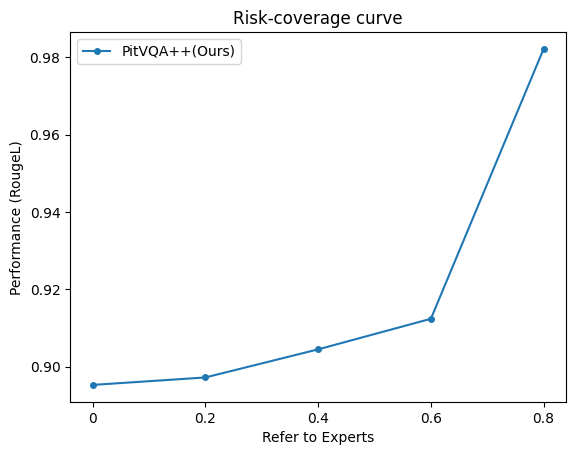

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays for easier manipulation
uncertainty_array = np.array(samplewise_unc_all)
rougeL_array = np.array(samplewise_rougeL)

# Get sorted indices based on uncertainty in descending order (highest uncertainty first)
sorted_indices = np.argsort(-uncertainty_array)

# Sort RougeL scores based on sorted uncertainty indices
sorted_rougeL = rougeL_array[sorted_indices]

# Define removal percentages
removal_percentages = [0, 20, 40, 60, 80]

print("Average RougeL after removing samples with highest uncertainty:")
avg_rougeL_by_refer = []
for percent in removal_percentages:
    num_to_remove = int(len(sorted_rougeL) * (percent / 100))
    remaining_rougeL = sorted_rougeL[num_to_remove:]  # Remove top N% uncertain samples
    avg_rougeL = np.mean(remaining_rougeL) if len(remaining_rougeL) > 0 else 0
    print(f"After removing top {percent}%: {avg_rougeL:.4f}")
    avg_rougeL_by_refer.append(avg_rougeL)

refer = np.array(['0' , 0.2 , 0.4 ,  0.6 ,  0.8  ])
avg_rougeL_by_refer = np.array(avg_rougeL_by_refer)

ax = plt.gca()
lineObjects = ax.plot(refer, avg_rougeL_by_refer.transpose(),marker='o',markersize=4)
legends = ['PitVQA++(Ours)']
ax.legend(lineObjects, legends)
ax.set_ylabel('Performance (RougeL)')
ax.set_xlabel("Refer to Experts")
ax.set_title('Risk-coverage curve');
plt.savefig("Risk_coverage_curve.pdf", bbox_inches='tight', dpi=1500)
